### 마스크 / 노마스크 분류

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications.resnet_v2 import ResNet101V2
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_dir = 'c:/workspace3/data/images/face_mask/Train'
test_dir = 'c:/workspace3/data/images/face_mask/Test'
val_dir = 'c:/workspace3/data/images/face_mask/Validation'

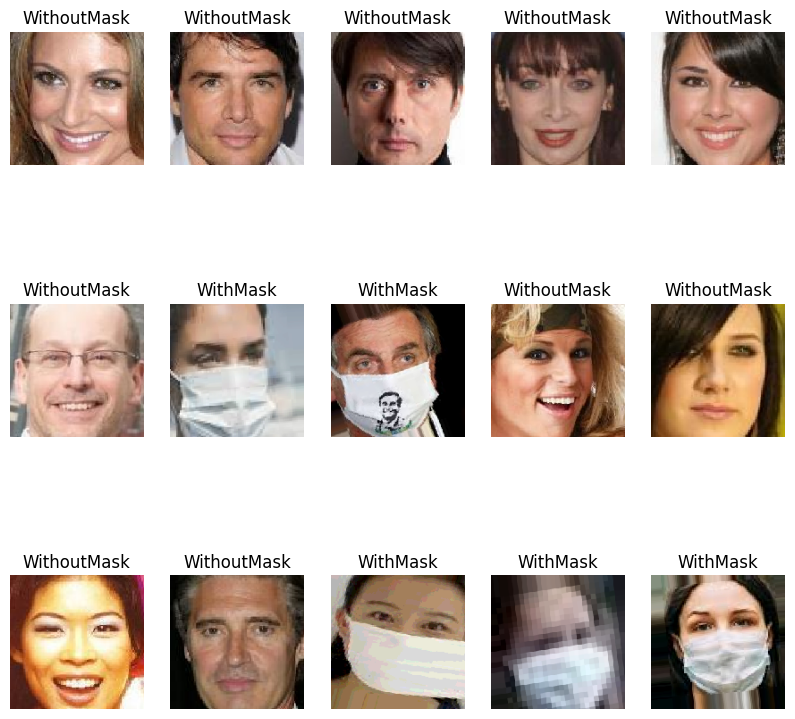

In [3]:
data_train = image_dataset_from_directory(train_dir,labels='inferred',
                                       label_mode='binary',interpolation='nearest',image_size=[150,150],batch_size=64,
                                       shuffle=True)

classes_train = data_train.class_names

plt.figure(figsize=(10,10))

for img, label in data_train.skip(50).take(1):
    for i in range(15):
        ax = plt.subplot(3,5,i+1)

        plt.imshow(img[i].numpy().astype('uint8'))
        plt.title(classes_train[int(label[i])])
        plt.axis('off')

clear_output()

In [4]:
classes = next(os.walk(train_dir))[1]

print(classes)

['WithMask', 'WithoutMask']


In [5]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.25,

                                   horizontal_flip=True,
                                   samplewise_center=True,
                                   samplewise_std_normalization=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
# 1. InceptionV3 모델

IMG_SIZE = (256, 256)                    # Image size is (256, 256) for Inception

train_dataset = train_datagen.flow_from_directory(train_dir, target_size=(IMG_SIZE),
                                                  color_mode="rgb",
                                                  batch_size=1,
                                                  shuffle=True,
                                                  class_mode="categorical")

test_dataset = test_datagen.flow_from_directory(test_dir, target_size=(IMG_SIZE),
                                                color_mode="rgb",
                                                batch_size=1,
                                                shuffle=True,
                                                class_mode="categorical")

validation_dataset = train_datagen.flow_from_directory(val_dir, target_size=(IMG_SIZE),
                                                       color_mode="rgb",
                                                       batch_size=1,
                                                       shuffle=True,
                                                       class_mode="categorical")

Found 10000 images belonging to 2 classes.
Found 992 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [7]:
import numpy as np

batch_size=1

n_img = train_dataset.n
steps = n_img // batch_size

X_train, y_train = [], []

for i in range(steps):
    a, b = train_dataset.next()

    X_train.extend(a)
    y_train.extend(b)

    if i > 200:
        break

X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

X_train.shape, y_train.shape

((202, 256, 256, 3), (202, 2))

In [8]:
import numpy as np

batch_size=1

n_img = validation_dataset.n
steps = n_img // batch_size

X_test, y_test = [], []

for i in range(steps):
    a, b = validation_dataset.next()

    X_test.extend(a)
    y_test.extend(b)

    if i > 100:
        break

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

X_test.shape, y_test.shape

((102, 256, 256, 3), (102, 2))

In [9]:
inceptionV3 = InceptionV3(weights='imagenet',include_top=False,input_shape=(256,256,3))

for layer in inceptionV3.layers:  
    layer.trainable = False

87910968/87910968 [==============================] - 3s 0us/step


In [10]:
model = Sequential()

model.add(inceptionV3)
model.add(Flatten())
model.add(Dense(2,activation='sigmoid'))  

model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 73728)             0         
                                                                 
 dense (Dense)               (None, 2)                 147458    
                                                                 
Total params: 21,950,242
Trainable params: 147,458
Non-trainable params: 21,802,784
_________________________________________________________________


In [11]:
callback = EarlyStopping(
    monitor='val_loss',
    min_delta = 0.00001,
    patience=3,
    verbose = 1,
    mode = "auto",
    baseline = None,
    restore_best_weights = False
    )

In [12]:
import gc

tf.keras.backend.clear_session()
gc.collect()

10865

In [13]:
inception_history = model.fit(X_train, y_train,
                              validation_data=(X_test, y_test),
                              batch_size=1,
                              epochs=1,
                              callbacks=callback)     

202/202 [==============================] - 40s 53ms/step - loss: 2.7235 - accuracy: 0.8812 - val_loss: 1.0116 - val_accuracy: 0.9314


In [14]:
inception_accuracy = model.evaluate(X_test, y_test, batch_size=1)
inception_accuracy

102/102 [==============================] - 3s 32ms/step - loss: 1.0116 - accuracy: 0.9314


[1.011581301689148, 0.9313725233078003]

In [15]:
tf.keras.backend.clear_session()
gc.collect()

2139

In [16]:
# 2. ResNet101V2

IMG_SIZE = (256, 256)                    # Image size is (256, 256) for ResNet

In [17]:
resnet101v2 = ResNet101V2(weights='imagenet',include_top=False,input_shape=(256,256,3))

for layer in resnet101v2.layers:
    layer.trainable = False

171317808/171317808 [==============================] - 6s 0us/step


In [18]:
model = Sequential()

model.add(resnet101v2)
model.add(Flatten())
model.add(Dense(2,activation='sigmoid'))

model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 8, 8, 2048)        42626560  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 2)                 262146    
                                                                 
Total params: 42,888,706
Trainable params: 262,146
Non-trainable params: 42,626,560
_________________________________________________________________


In [19]:
resnet_history = model.fit(X_train, y_train,
                           validation_data=(X_test, y_test),
                           epochs=1,
                           batch_size=1,
                           callbacks=callback)

202/202 [==============================] - 21s 78ms/step - loss: 26.7934 - accuracy: 0.7871 - val_loss: 21.5622 - val_accuracy: 0.8039


In [20]:
resnet_accuracy = model.evaluate(X_test, y_test, batch_size=1)
resnet_accuracy

102/102 [==============================] - 5s 46ms/step - loss: 21.5622 - accuracy: 0.8039


[21.56221580505371, 0.8039215803146362]

In [21]:
# 3.VGG19 모델

IMG_SIZE = (224, 224)                    # Image size is (224, 224) for VGG19

train_dataset = train_datagen.flow_from_directory(train_dir, target_size=(IMG_SIZE),
                                                  color_mode="rgb",
                                                  batch_size=1,
                                                  shuffle=True,
                                                  class_mode="categorical")

test_dataset = test_datagen.flow_from_directory(test_dir, target_size=(IMG_SIZE),
                                                color_mode="rgb",
                                                batch_size=1,
                                                shuffle=True,
                                                class_mode="categorical")

validation_dataset = train_datagen.flow_from_directory(val_dir, target_size=(IMG_SIZE),
                                                       color_mode="rgb",
                                                       batch_size=1,
                                                       shuffle=True,
                                                       class_mode="categorical")

Found 10000 images belonging to 2 classes.
Found 992 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [22]:
import numpy as np

batch_size=1

n_img = train_dataset.n
steps = n_img // batch_size

X_train, y_train = [], []

for i in range(steps):
    a, b = train_dataset.next()

    X_train.extend(a)
    y_train.extend(b)

    if i > 200:
        break

X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

X_train.shape, y_train.shape

((202, 224, 224, 3), (202, 2))

In [23]:
import numpy as np

batch_size=1

n_img = validation_dataset.n
steps = n_img // batch_size

X_test, y_test = [], []

for i in range(steps):
    a, b = validation_dataset.next()
    X_test.extend(a)
    y_test.extend(b)

    if i > 100:
        break

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

X_test.shape, y_test.shape

((102, 224, 224, 3), (102, 2))

In [24]:
vgg19 = VGG19(weights='imagenet',
              include_top=False,
              input_shape=(224,224,3))

for layer in vgg19.layers:
    layer.trainable = False

model = Sequential()
model.add(vgg19)
model.add(Flatten())
model.add(Dense(2,activation='sigmoid'))

model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

model.summary()

80134624/80134624 [==============================] - 3s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 2)                 50178     
                                                                 
Total params: 20,074,562
Trainable params: 50,178
Non-trainable params: 20,024,384
_________________________________________________________________


In [25]:
tf.keras.backend.clear_session()

gc.collect()

2938

In [26]:
vgg19_history = model.fit(X_train, y_train,
                          validation_data=(X_test, y_test),
                          epochs=1,
                          batch_size=1,
                          callbacks=callback)

202/202 [==============================] - 10s 43ms/step - loss: 0.5893 - accuracy: 0.8465 - val_loss: 0.2286 - val_accuracy: 0.8922


In [27]:
vgg19_accuracy = model.evaluate(X_test, y_test, batch_size=1)

vgg19_accuracy

102/102 [==============================] - 3s 28ms/step - loss: 0.2286 - accuracy: 0.8922


[0.22864608466625214, 0.8921568393707275]

In [28]:
tf.keras.backend.clear_session()

gc.collect()

1443

In [29]:
# 4.VGG16 모델

IMG_SIZE = (224, 224)                    # Image size is (224, 224) for VGG16

In [30]:
vgg16 = VGG16(weights='imagenet',
              include_top=False,
              input_shape=(224,224,3))

for layer in vgg16.layers:

    layer.trainable = False
model = Sequential()
model.add(vgg16)
model.add(Flatten())
model.add(Dense(2,activation='sigmoid'))

model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

model.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 2)                 50178     
                                                                 
Total params: 14,764,866
Trainable params: 50,178
Non-trainable params: 14,714,688
_________________________________________________________________


In [31]:
vgg16_history = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                          epochs=1,
                          batch_size=1,
                          callbacks=callback)

202/202 [==============================] - 7s 35ms/step - loss: 0.3593 - accuracy: 0.8911 - val_loss: 0.0859 - val_accuracy: 0.9804


In [32]:
vgg16_accuracy = model.evaluate(X_test, y_test, batch_size=1)

102/102 [==============================] - 2s 22ms/step - loss: 0.0859 - accuracy: 0.9804


In [33]:
tf.keras.backend.clear_session()

gc.collect()

2139

In [34]:
# 5. MobileNetV2 모델

IMG_SIZE = (150, 150)                    # image size is (150,150) for MobileNet

train_dataset = train_datagen.flow_from_directory(train_dir, target_size=(IMG_SIZE),
                                                  color_mode="rgb",
                                                  batch_size=1,
                                                  shuffle=True,
                                                  class_mode="categorical")
                                                  
test_dataset = test_datagen.flow_from_directory(test_dir, target_size=(IMG_SIZE),
                                                color_mode="rgb",
                                                batch_size=1,
                                                shuffle=True,
                                                class_mode="categorical")

validation_dataset = train_datagen.flow_from_directory(val_dir, target_size=(IMG_SIZE),
                                                       color_mode="rgb",
                                                       batch_size=1,  
                                                       shuffle=True,
                                                       class_mode="categorical")

Found 10000 images belonging to 2 classes.
Found 992 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [35]:
import numpy as np

batch_size=2

n_img = train_dataset.n
steps = n_img // batch_size

X_train, y_train = [], []

for i in range(steps):
    a, b = train_dataset.next()

    X_train.extend(a)
    y_train.extend(b)

    if i > 400:
        break

X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

X_train.shape, y_train.shape

((402, 150, 150, 3), (402, 2))

In [36]:
import numpy as np

batch_size=1

n_img = validation_dataset.n
steps = n_img // batch_size

X_test, y_test = [], []

for i in range(steps):
    a, b = validation_dataset.next()

    X_test.extend(a)
    y_test.extend(b)

    if i > 100:
        break

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

X_test.shape, y_test.shape

((102, 150, 150, 3), (102, 2))

In [37]:
mobilenet = MobileNetV2(weights = "imagenet",
                        include_top = False,
                        input_shape=(150,150,3))

for layer in mobilenet.layers:
    layer.trainable = False

model = Sequential()

model.add(mobilenet)
model.add(Flatten())
model.add(Dense(2,activation='sigmoid'))

model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 32000)             0         
                                                                 
 dense (Dense)               (None, 2)                 64002     
                                                                 
Total params: 2,321,986
Trainable params: 64,002
Non-trainable params: 2,257,984
_________________________________________________________________


In [38]:
mobilenet_history = model.fit(X_train, y_train,
                              validation_data=(X_test, y_test),
                              epochs=1,
                              batch_size=1,
                              callbacks=callback)

402/402 [==============================] - 11s 16ms/step - loss: 2.1047 - accuracy: 0.8980 - val_loss: 1.2391 - val_accuracy: 0.9216


In [39]:
mobilenet_accuracy = model.evaluate(X_test, y_test,batch_size=1)

102/102 [==============================] - 1s 12ms/step - loss: 1.2391 - accuracy: 0.9216


In [40]:
# 6. DenseNet 모델

IMG_SIZE = (128, 128)                    # image size is (128, 128) for DenseNet201

train_dataset = train_datagen.flow_from_directory(train_dir, target_size=(IMG_SIZE),
                                                  color_mode="rgb",
                                                  batch_size=1,
                                                  shuffle=True,
                                                  class_mode="categorical")

test_dataset = test_datagen.flow_from_directory(test_dir, target_size=(IMG_SIZE),
                                                color_mode="rgb",
                                                batch_size=1,
                                                shuffle=True,
                                                class_mode="categorical")

validation_dataset = train_datagen.flow_from_directory(val_dir, target_size=(IMG_SIZE),
                                                       color_mode="rgb",
                                                       batch_size=1,
                                                       shuffle=True,
                                                       class_mode="categorical")

Found 10000 images belonging to 2 classes.
Found 992 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [41]:
import numpy as np

batch_size=2

n_img = train_dataset.n
steps = n_img // batch_size

X_train, y_train = [], []

for i in range(steps):
    a, b = train_dataset.next()

    X_train.extend(a)
    y_train.extend(b)

    if i > 400:
        break

X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

X_train.shape, y_train.shape

((402, 128, 128, 3), (402, 2))

In [42]:
import numpy as np

batch_size=1

n_img = validation_dataset.n
steps = n_img // batch_size

X_test, y_test = [], []

for i in range(steps):
    a, b = validation_dataset.next()

    X_test.extend(a)
    y_test.extend(b)

    if i > 100:
        break

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

X_test.shape, y_test.shape

((102, 128, 128, 3), (102, 2))

In [43]:
tf.keras.backend.clear_session()

gc.collect()

9070

In [44]:
densenet = DenseNet201(weights = "imagenet",
                       include_top = False,
                       input_shape=(128,128,3))

for layer in densenet.layers:
    layer.trainable = False

model = Sequential()

model.add(densenet)
model.add(Flatten())
model.add(Dense(2,activation='sigmoid'))

model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

model.summary()

74836368/74836368 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 4, 4, 1920)        18321984  
                                                                 
 flatten (Flatten)           (None, 30720)             0         
                                                                 
 dense (Dense)               (None, 2)                 61442     
                                                                 
Total params: 18,383,426
Trainable params: 61,442
Non-trainable params: 18,321,984
_________________________________________________________________


In [45]:
densenet_history = model.fit(X_train, y_train,
                             validation_data=(X_test, y_test),
                             epochs=1,
                             batch_size=1,
                             callbacks=callback)

402/402 [==============================] - 37s 65ms/step - loss: 0.8702 - accuracy: 0.9428 - val_loss: 1.1203 - val_accuracy: 0.9706


In [46]:
densenet_accuracy = model.evaluate(X_test, y_test, batch_size=1)

102/102 [==============================] - 5s 46ms/step - loss: 1.1203 - accuracy: 0.9706


In [47]:
model_histories = [inception_history, resnet_history ,vgg19_history ,
                   vgg16_history ,mobilenet_history,densenet_history]

names = ['InceptionV3','ResNet101V2', 'VGG19', 'VGG16', 'MobileNetV2','DenseNet201']

In [48]:
data={'Nets':['InceptionV3','ResNet101V2', 'VGG19', 'VGG16', 'MobileNetV2','DenseNet201'],
      'Accuracy':[inception_accuracy[1],resnet_accuracy[1],vgg19_accuracy[1],vgg16_accuracy[1],
                  mobilenet_accuracy[1],densenet_accuracy[1]]}

df =pd.DataFrame(data)

df.sort_values('Accuracy', ascending=False) #내림차순 정렬

,Nets,Accuracy
3,VGG16,0.980392
5,DenseNet201,0.970588
0,InceptionV3,0.931373
4,MobileNetV2,0.921569
2,VGG19,0.892157
1,ResNet101V2,0.803922
